In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

Accuracy: 0.5555555555555556
Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.50      0.60         6
         1.0       0.40      0.67      0.50         3

    accuracy                           0.56         9
   macro avg       0.57      0.58      0.55         9
weighted avg       0.63      0.56      0.57         9

Intercept: 0.17037270508803862
Coefficient: -0.4224329512735138


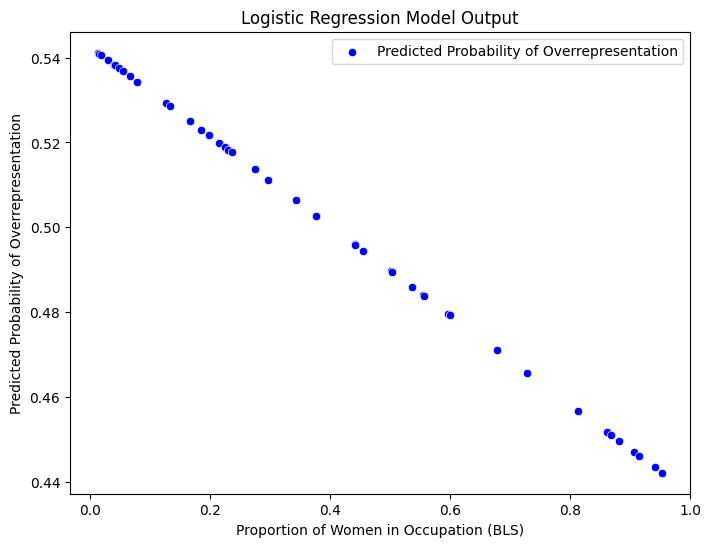

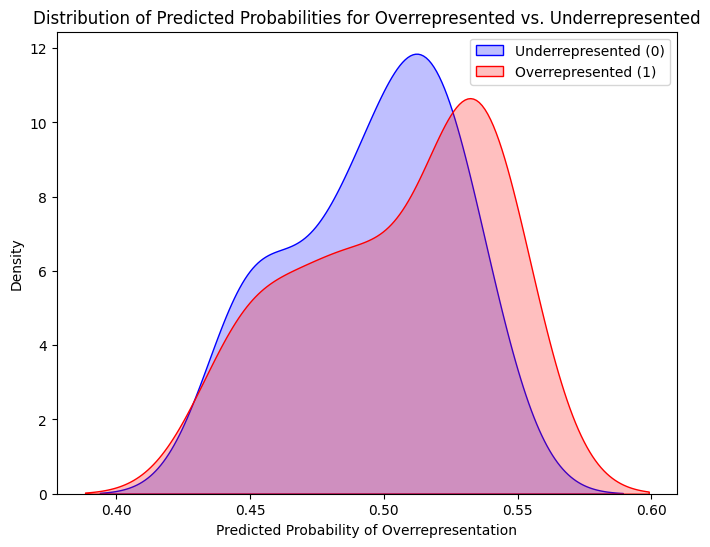

In [ ]:
url = "https://raw.githubusercontent.com/mjskay/gender-in-image-search/master/data/public/filtered_bls_occupations_with_search_gender_proportions.csv"
df = pd.read_csv(url)

for index, row in df.iterrows():
  if row['search_p_women'] > row['bls_p_women']:
      df.at[index, 'overrepresented'] = 1
  else:
      df.at[index, 'overrepresented'] = 0

X = df[['bls_p_women']]
y = df['overrepresented']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

intercept = model.intercept_[0]
coefficient = model.coef_[0][0]

print(f'Accuracy: {accuracy}')
print("Classification Report:\n", report)
print("Intercept:", intercept)
print("Coefficient:", coefficient)

df['predicted_prob'] = model.predict_proba(df[['bls_p_women']])[:, 1]

df_sorted = df.sort_values(by="bls_p_women")

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_sorted['bls_p_women'], y=df_sorted['predicted_prob'], color="blue", label="Predicted Probability of Overrepresentation")

plt.xlabel("Proportion of Women in Occupation (BLS)")
plt.ylabel("Predicted Probability of Overrepresentation")
plt.title("Logistic Regression Model Output")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
sns.kdeplot(df.loc[df['overrepresented'] == 0, 'predicted_prob'], fill=True, label="Underrepresented (0)", color="blue")
sns.kdeplot(df.loc[df['overrepresented'] == 1, 'predicted_prob'], fill=True, label="Overrepresented (1)", color="red")

plt.xlabel("Predicted Probability of Overrepresentation")
plt.ylabel("Density")
plt.title("Distribution of Predicted Probabilities for Overrepresented vs. Underrepresented")
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 0.337002
         Iterations 6


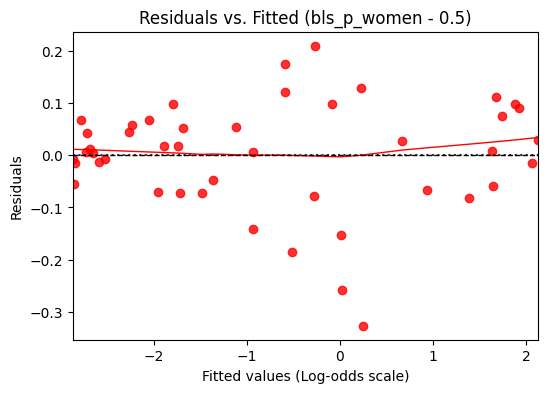

In [ ]:
df["bls_p_women_centered"] = df["bls_p_women"] - 0.5

X = sm.add_constant(df["bls_p_women_centered"])  # Add intercept
y = df["search_p_women"]  # Target variable (binary: 0 or 1)

model = sm.Logit(y, X).fit()

df["residuals"] = model.resid_response

df["fitted_values"] = model.fittedvalues

plt.figure(figsize=(6, 4))
sns.residplot(x=df["fitted_values"], y=df["residuals"], lowess=True, color="red", line_kws={'lw':1})
plt.xlabel("Fitted values (Log-odds scale)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (bls_p_women - 0.5)")
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.show()

Optimization terminated successfully.
         Current function value: 0.345818
         Iterations 6


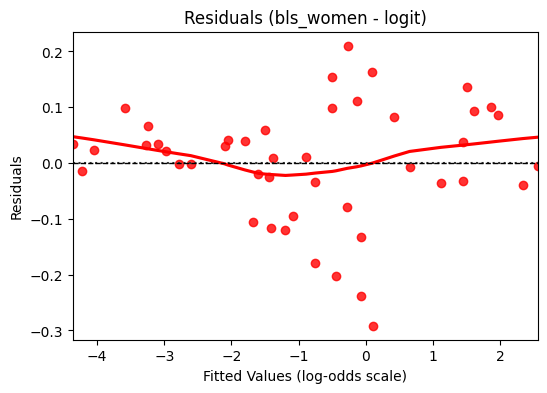

In [ ]:
df['bls_p_women_logit'] = np.log(df['bls_p_women'] / (1 - df['bls_p_women']))


X = sm.add_constant(df["bls_p_women_logit"])
y = df["search_p_women"]

model = sm.Logit(y, X).fit()

df["residuals"] = model.resid_response

df["fitted_values"] = model.fittedvalues


plt.figure(figsize=(6, 4))
sns.residplot(x=df["fitted_values"], y=df["residuals"], lowess=True, color = "red", line_kws={"color": "red"})
plt.xlabel("Fitted Values (log-odds scale)")
plt.ylabel("Residuals")
plt.title("Residuals (bls_women - logit)")
plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.show()

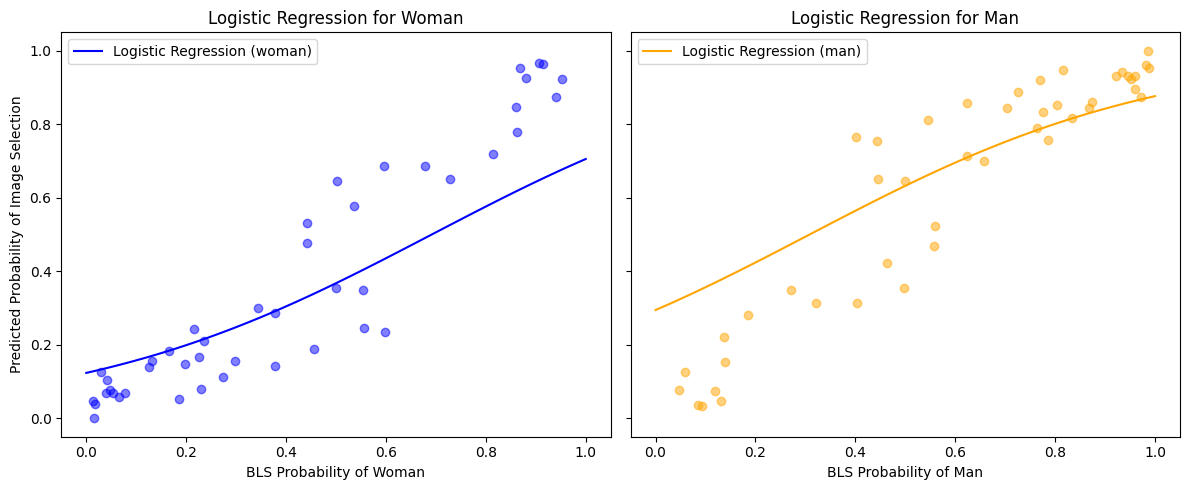

In [ ]:
#male probability computation
if 'bls_p_men' not in df.columns:
    df['bls_p_men'] = 1 - df['bls_p_women']

if 'search_p_men' not in df.columns:
    df['search_p_men'] = 1 - df['search_p_women']

#melt gender probabilities into rows - creating 2 instances of each profession
df_long = df.melt(id_vars=['search_p_women', 'search_p_men'],
                  value_vars=['bls_p_women', 'bls_p_men'],
                  var_name='Gender', value_name='bls_p_image_gender')

df_long['Gender'] = df_long['Gender'].replace({
    'bls_p_women': 'woman',
    'bls_p_men': 'man'
})

image_selected_values = []

for index, row in df_long.iterrows():
    if row['Gender'] == 'woman':
        image_selected_values.append(row['search_p_women'])
    else:
        image_selected_values.append(row['search_p_men'])

df_long['image_selected'] = image_selected_values

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, gender in enumerate(['woman', 'man']):
    gender_df = df_long[df_long['Gender'] == gender]

    X = gender_df[['bls_p_image_gender']].values
    y = (gender_df['image_selected'] > 0.5).astype(int)

    model = LogisticRegression()
    model.fit(X, y)

    x_range = np.linspace(0, 1, 100).reshape(-1, 1)
    preds = model.predict_proba(x_range)[:, 1]

    ax = axes[i]
    ax.plot(x_range, preds, color=colors[gender], label=f'Logistic Regression ({gender})')
    ax.scatter(gender_df['bls_p_image_gender'], gender_df['image_selected'], alpha=0.5, color=colors[gender])
    ax.set_title(f'Logistic Regression for {gender.capitalize()}')
    ax.set_xlabel(f'BLS Probability of {gender.capitalize()}')
    if i == 0:
        ax.set_ylabel("Predicted Probability of Image Selection")
    ax.legend()

# plot without confidence interval
plt.tight_layout()
plt.show()